# Demo
## STAT 4830

### In this file we have some of our most successful models for solving this problem. They have been attached with some preliminary testing to illustrate some of the results that we found as detailed in our final reports.



We use grams of air flow into the engine as our benchmark to represent the energy consumption of a vehicle on a route, due to MAF [g/sec] (Mass Air Flow) being the only accurate metric that could be used as a target column within the dataset that could be interpreted by the model without having the model produce nonsense predictions.

In [34]:
!pip install osmnx networkx matplotlib numpy shapely
!pip install matplotlib

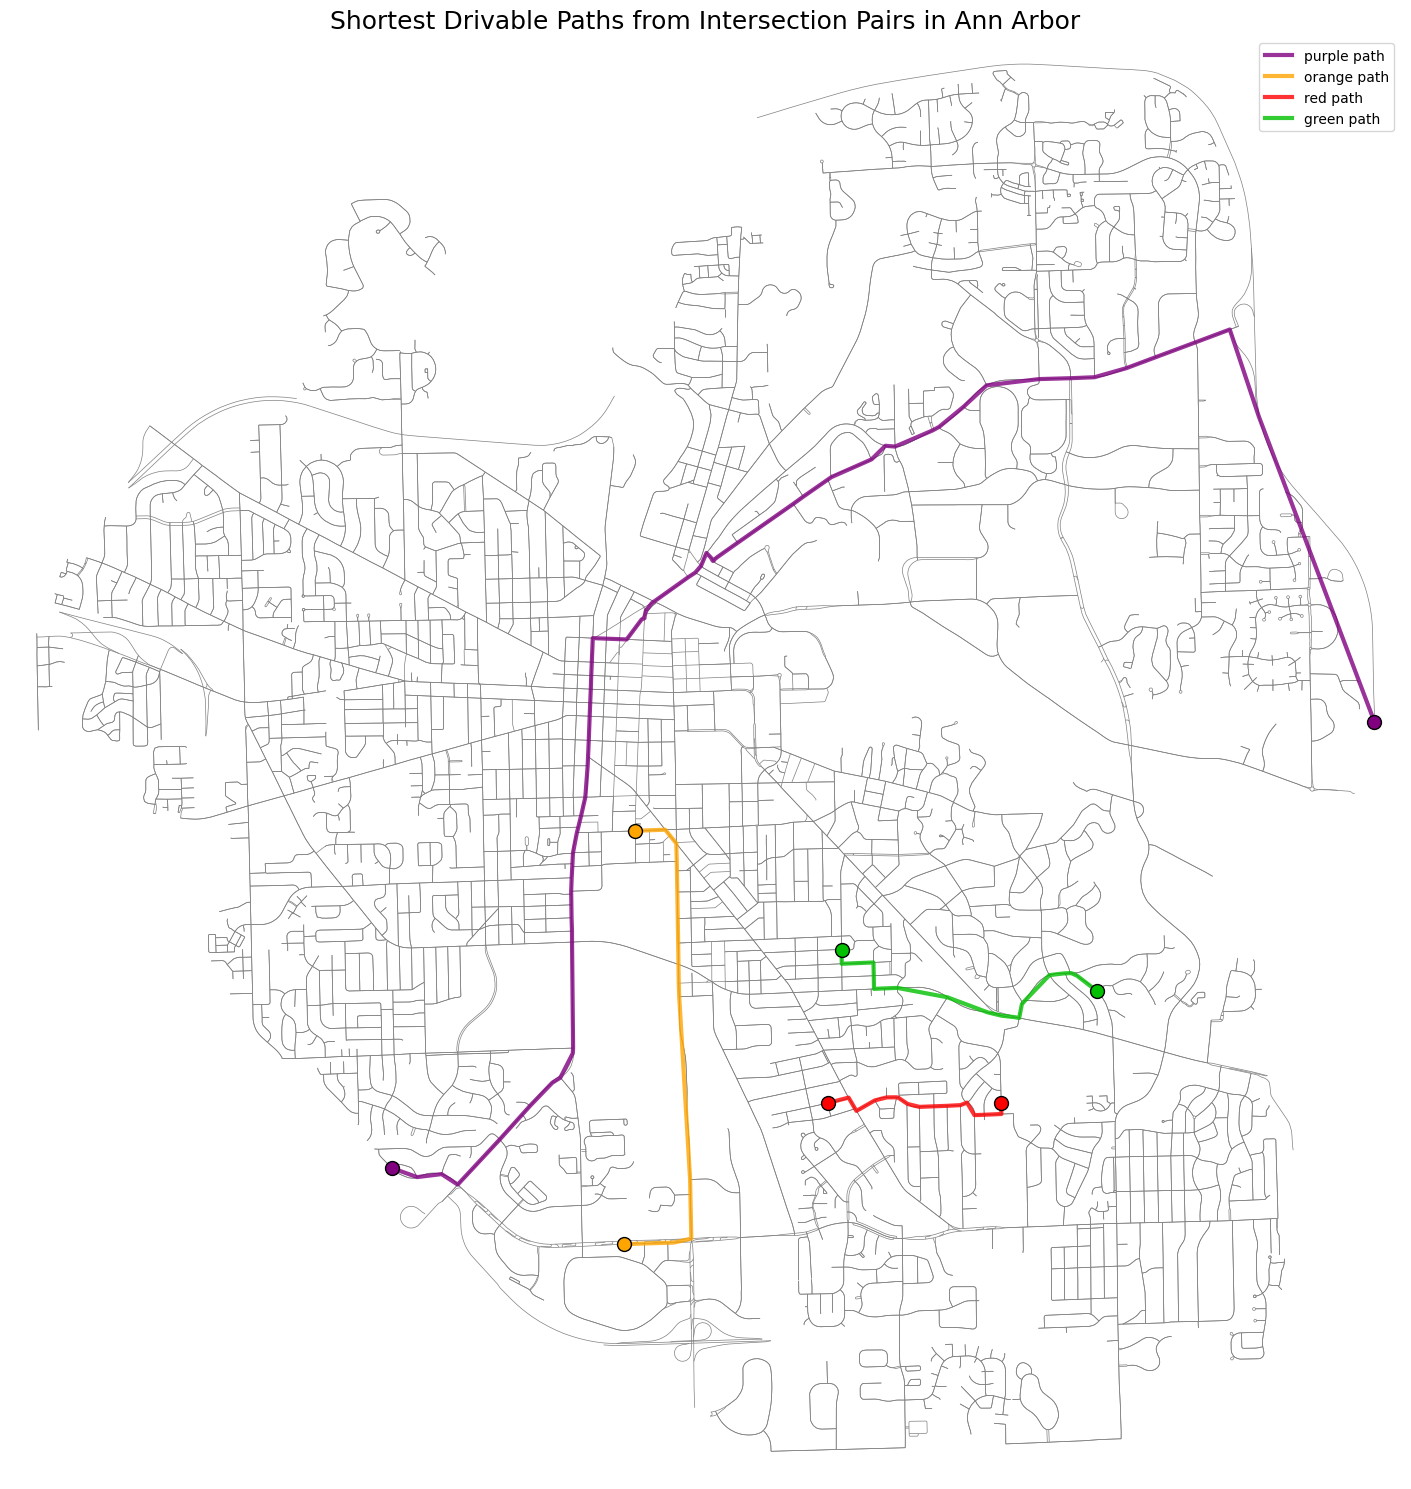

Distance of the purple route: 14037.92 meters (14.04 km)


In [35]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

# Use OSMnx settings
ox.settings.use_cache = True
ox.settings.log_console = True

# Manually specified marker coordinates from your provided intersections
markers = {
    'purple_square': (42.2406, -83.7794),       # Ann Arbor-Saline Rd & I-94
    'purple_triangle': (42.2803, -83.6695),     # Geddes Rd & US-23
    'yellow_square': (42.2430, -83.7450),       # State St & Hilton Blvd
    'yellow_triangle': (42.2716, -83.7448),     # State St & Granger Ave
    'red_triangle': (42.2535, -83.7268),        # Page Ave & Rosewood St
    'red_square': (42.2530, -83.7105),          # Independence Blvd & Kimberly Rd
    'green_triangle': (42.2635, -83.7260),      # Shadford Rd & Harding Rd
    'green_square': (42.2602, -83.7025)         # Glenwood Rd & Washtenaw Ave
}

# Download the drivable street network for Ann Arbor
G = ox.graph_from_place('Ann Arbor, Michigan, USA', network_type='drive')

# Snap each marker to the nearest node in the graph
nearest_nodes = {
    name: ox.distance.nearest_nodes(G, lon, lat)
    for name, (lat, lon) in markers.items()
}

# Define color-coded route pairs
color_routes = {
    'purple': ('purple_square', 'purple_triangle'),
    'orange': ('yellow_square', 'yellow_triangle'),
    'red': ('red_triangle', 'red_square'),
    'green': ('green_triangle', 'green_square')
}

# Define plotting colors
colors = {
    'purple': '#800080',
    'orange': '#FFA500',
    'red': '#FF0000',
    'green': '#00C000'
}

# Begin plotting
fig, ax = plt.subplots(figsize=(15, 15))
ox.plot_graph(G, ax=ax, node_size=0, edge_linewidth=0.5, edge_color='gray', show=False, close=False)

# Store purple route separately to calculate distance later
purple_route = None

# Plot each route
for color, (start_marker, end_marker) in color_routes.items():
    start_node = nearest_nodes[start_marker]
    end_node = nearest_nodes[end_marker]

    try:
        # Find the shortest path
        route = nx.shortest_path(G, start_node, end_node, weight='length')

        # Save purple route separately
        if color == 'purple':
            purple_route = route

        # Extract x and y coordinates along the path
        x = [G.nodes[node]['x'] for node in route]
        y = [G.nodes[node]['y'] for node in route]

        # Plot the route
        ax.plot(x, y, color=colors[color], linewidth=3, alpha=0.8, label=f"{color} path")

        # Mark the start and end nodes
        ax.scatter(G.nodes[start_node]['x'], G.nodes[start_node]['y'], color=colors[color], edgecolors='black', s=100, zorder=5)
        ax.scatter(G.nodes[end_node]['x'], G.nodes[end_node]['y'], color=colors[color], edgecolors='black', s=100, zorder=5)

    except nx.NetworkXNoPath:
        print(f"No drivable path between {start_marker} and {end_marker}")

# Final plot adjustments
plt.title('Shortest Drivable Paths from Intersection Pairs in Ann Arbor', fontsize=18)
plt.legend()
plt.tight_layout()
plt.savefig('ann_arbor_shortest_paths_drive.png', dpi=300)
plt.show()

# Calculate and print purple route distance
if purple_route:
    purple_distance_meters = sum(
        G.edges[u, v, 0]['length'] for u, v in zip(purple_route[:-1], purple_route[1:])
    )
    purple_distance_km = purple_distance_meters / 1000
    print(f"Distance of the purple route: {purple_distance_meters:.2f} meters ({purple_distance_km:.2f} km)")


Insert the gnn_model.pth file below

In [36]:
from google.colab import files
uploaded = files.upload()

Saving GNN_model.pth to GNN_model (3).pth


In [37]:
!pip install torch_geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html


The GNN model definition

In [38]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Dropout, LayerNorm, GRU
from torch_geometric.nn import GINEConv

class GNNPathEnergyPredictor(torch.nn.Module):
    def __init__(self, node_dim, edge_dim, hid=128, rnn_hid=128, nlayers=4, drop=0.3):
        super().__init__()
        self.node_emb = Linear(node_dim, hid)
        self.edge_emb = Linear(edge_dim, hid)
        self.convs = torch.nn.ModuleList()
        self.norms = torch.nn.ModuleList()

        for _ in range(nlayers):
            mlp = torch.nn.Sequential(Linear(hid, hid), ReLU(), Linear(hid, hid))
            self.convs.append(GINEConv(mlp, edge_dim=hid))
            self.norms.append(LayerNorm(hid))

        self.rnn = GRU(input_size=3*hid, hidden_size=rnn_hid, batch_first=True)
        self.decoder = torch.nn.Sequential(
            Linear(rnn_hid, hid),
            ReLU(),
            Dropout(drop),
            Linear(hid, 1)
        )

    def forward(self, graph, path_list):
        device = next(self.parameters()).device
        x = self.node_emb(graph.x.to(device))
        ea = self.edge_emb(graph.edge_attr.to(device))

        # GINE layers
        for conv, norm in zip(self.convs, self.norms):
            res = x
            x = conv(x, graph.edge_index.to(device), ea)
            x = norm(x)
            x = F.relu(x) + res

        emb = x

        # build per-path sequences of [src_emb | edge_emb | dst_emb]
        all_seqs = []
        for path in path_list:  # For each path in the batch
            seqs = []
            # Handle both tensor and list inputs
            if isinstance(path, torch.Tensor):
                eidx = path.to(device)
            else:
                eidx = torch.tensor(path, device=device)

            if len(eidx.shape) == 0:  # Single edge index
                eidx = eidx.unsqueeze(0)

            src_nodes = graph.edge_index[0, eidx].to(device)
            dst_nodes = graph.edge_index[1, eidx].to(device)
            edge_features = ea[eidx]

            seq = torch.cat([emb[src_nodes], edge_features, emb[dst_nodes]], dim=1)
            all_seqs.append(seq)

        # Process each sequence separately to avoid dimension issues
        results = []
        for seq in all_seqs:
            # Add batch dimension if needed
            if len(seq.shape) == 2:
                seq = seq.unsqueeze(0)  # Add batch dimension

            # Process through RNN
            _, h = self.rnn(seq)
            out = self.decoder(h.squeeze(0)).squeeze(-1)
            results.append(out)

        # Concatenate results
        if len(results) == 1:
            return results[0]
        return torch.cat(results)

Loading the saved state of the model

In [39]:
gnnmodel = GNNPathEnergyPredictor(node_dim=2, edge_dim=2)
gnnmodel.load_state_dict(torch.load("GNN_model.pth", map_location='cpu'))
gnnmodel.eval()

GNNPathEnergyPredictor(
  (node_emb): Linear(in_features=2, out_features=128, bias=True)
  (edge_emb): Linear(in_features=2, out_features=128, bias=True)
  (convs): ModuleList(
    (0-3): 4 x GINEConv(nn=Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    ))
  )
  (norms): ModuleList(
    (0-3): 4 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (rnn): GRU(384, 128, batch_first=True)
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)

Building a graph from OSMNX that is compatible with our model

In [40]:
from torch_geometric.data import Data
import numpy as np

# Build edge index
edge_index = []
edge_attr = []
node_features = []

# Map OSM node id → index
node_id_map = {nid: i for i, nid in enumerate(G.nodes())}
idx2node = {i: nid for nid, i in node_id_map.items()}

# Collect node features (lat, lon normalized)
lats = [G.nodes[n]['y'] for n in G.nodes()]
lons = [G.nodes[n]['x'] for n in G.nodes()]
lat_min, lat_max = min(lats), max(lats)
lon_min, lon_max = min(lons), max(lons)

def normalize(val, minval, maxval):
    return (val - minval) / (maxval - minval + 1e-6)

for nid in G.nodes():
    norm_lat = normalize(G.nodes[nid]['y'], lat_min, lat_max)
    norm_lon = normalize(G.nodes[nid]['x'], lon_min, lon_max)
    node_features.append([norm_lat, norm_lon])

for u, v, data in G.edges(data=True):
    u_idx = node_id_map[u]
    v_idx = node_id_map[v]
    length = data.get('length', 1.0)
    maxspeed = data.get('maxspeed', 0)
    if isinstance(maxspeed, list): maxspeed = maxspeed[0]
    try:
        speed = float(str(maxspeed).split()[0])
    except:
        speed = 0.0
    norm_len = length / 1000  # km scale
    norm_speed = min(speed / 130, 1.0)  # cap at 130 km/h
    edge_index.append([u_idx, v_idx])
    edge_attr.append([norm_len, norm_speed])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr, dtype=torch.float)
x = torch.tensor(node_features, dtype=torch.float)

graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)


In [41]:
# Create lookup for (u_idx, v_idx) to edge index
edge_lookup = {
    (u.item(), v.item()): i for i, (u, v) in enumerate(edge_index.t())
}

def path_to_edge_indices(node_path):
    edge_ids = []
    for u, v in zip(node_path[:-1], node_path[1:]):
        u_idx = node_id_map[u]
        v_idx = node_id_map[v]
        if (u_idx, v_idx) in edge_lookup:
            edge_ids.append(edge_lookup[(u_idx, v_idx)])
        else:
            print(f"Missing edge: {(u_idx, v_idx)}")
    return edge_ids


Predicting energy usage of shortest path

In [42]:
for color, (start_marker, end_marker) in color_routes.items():
    start = nearest_nodes[start_marker]
    end = nearest_nodes[end_marker]

    try:
        dijkstra_path = nx.shortest_path(G, start, end, weight='length')
        edge_indices = path_to_edge_indices(dijkstra_path)

        if edge_indices:
            with torch.no_grad():
                prediction = gnnmodel(graph, [edge_indices])
                energy_pred = prediction.item()
                route_len = sum(G.edges[u, v, 0]['length'] for u, v in zip(dijkstra_path[:-1], dijkstra_path[1:]))

                print(f"{color.upper()} path:")
                print(f"  Dijkstra distance: {route_len:.2f} meters")
                print(f"  GNN energy estimate: {energy_pred:.4f} predicted grams of airmass flowing into engine from start to end of trip")
                print("-" * 40)

    except nx.NetworkXNoPath:
        print(f"No path found for {color}")


PURPLE path:
  Dijkstra distance: 14037.92 meters
  GNN energy estimate: 10.4141 predicted grams of airmass flowing into engine from start to end of trip
----------------------------------------
ORANGE path:
  Dijkstra distance: 3870.99 meters
  GNN energy estimate: 9.4992 predicted grams of airmass flowing into engine from start to end of trip
----------------------------------------
RED path:
  Dijkstra distance: 1570.88 meters
  GNN energy estimate: 9.0353 predicted grams of airmass flowing into engine from start to end of trip
----------------------------------------
GREEN path:
  Dijkstra distance: 2512.03 meters
  GNN energy estimate: 8.9489 predicted grams of airmass flowing into engine from start to end of trip
----------------------------------------


Function for GNN to find energy efficient path defined below

In [43]:
import heapq

def gnn_energy_path(graph_data, model, start_osm, end_osm, node_id_map, edge_lookup):
    start = node_id_map[start_osm]
    end = node_id_map[end_osm]

    # Priority queue: (predicted_energy, current_node, path_so_far, edge_ids_so_far)
    queue = [(0, start, [start], [])]
    visited = set()

    while queue:
        total_energy, curr_node, path, edge_ids = heapq.heappop(queue)

        if curr_node == end:
            return path, edge_ids, total_energy  # Found optimal path

        if curr_node in visited:
            continue
        visited.add(curr_node)

        # Find outgoing edges from current node
        out_edges = graph_data.edge_index.t()[(graph_data.edge_index[0] == curr_node).nonzero(as_tuple=True)[0]]
        for e in out_edges:
            u, v = e.tolist()
            e_idx = edge_lookup.get((u, v), None)
            if e_idx is None or v in visited:
                continue

            new_path = path + [v]
            new_edge_ids = edge_ids + [e_idx]

            # Predict energy for this partial path
            with torch.no_grad():
                pred_energy = model(graph_data, [new_edge_ids]).item()

            heapq.heappush(queue, (pred_energy, v, new_path, new_edge_ids))

    return None, None, float('inf')  # No path found


###Comparing routes picked by GNN (energy efficiency aware) to Dijkstras routes that only rely on distance, based on the above endpoints in the first dijkstras simulation



PURPLE route comparison:
  Dijkstra path length: 14037.92 meters
  Dijkstra predicted energy: 10.4141
  GNN-optimal path length: 20346.19 meters
  GNN-optimal predicted energy: 10.3685 avg grams of MAF/s

ORANGE route comparison:
  Dijkstra path length: 3870.99 meters
  Dijkstra predicted energy: 9.4992
  GNN-optimal path length: 7574.99 meters
  GNN-optimal predicted energy: 9.5605 avg grams of MAF/s

RED route comparison:
  Dijkstra path length: 1570.88 meters
  Dijkstra predicted energy: 9.0353
  GNN-optimal path length: 2901.14 meters
  GNN-optimal predicted energy: 8.9071 avg grams of MAF/s

GREEN route comparison:
  Dijkstra path length: 2512.03 meters
  Dijkstra predicted energy: 8.9489
  GNN-optimal path length: 3644.48 meters
  GNN-optimal predicted energy: 8.6362 avg grams of MAF/s


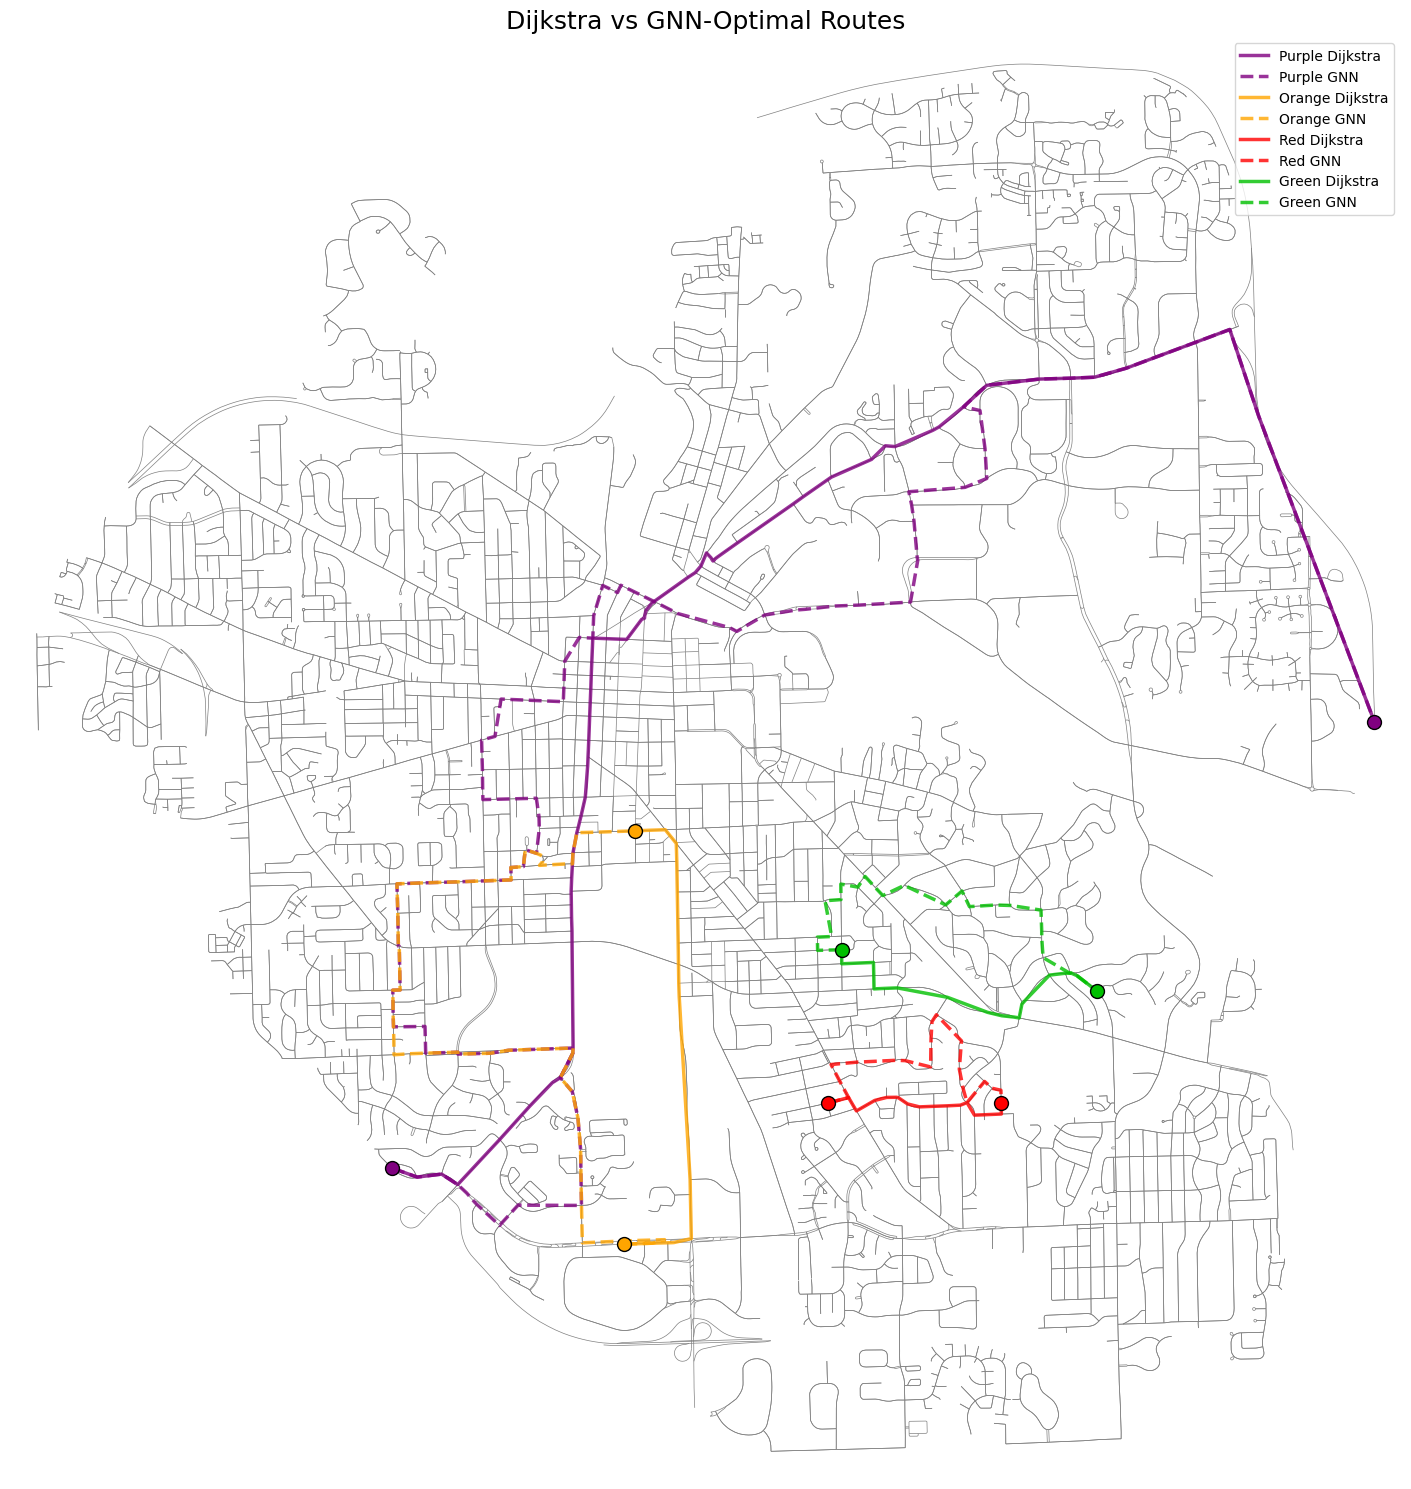


Comparison Table:
    Color  Dijkstra Length (m)  Dijkstra Energy  GNN Length (m)  GNN Energy
0  Purple             14037.92          10.4141        20346.19     10.3685
1  Orange              3870.99           9.4992         7574.99      9.5605
2     Red              1570.88           9.0353         2901.14      8.9071
3   Green              2512.03           8.9489         3644.48      8.6362


In [44]:
import pandas as pd
import matplotlib.pyplot as plt

route_stats = []

# Start plotting setup
fig, ax = plt.subplots(figsize=(15, 15))
ox.plot_graph(G, ax=ax, node_size=0, edge_linewidth=0.5, edge_color='gray', show=False, close=False)

for color, (start_marker, end_marker) in color_routes.items():
    print(f"\n{color.upper()} route comparison:")

    start_osm = nearest_nodes[start_marker]
    end_osm = nearest_nodes[end_marker]

    try:
        # --- Dijkstra ---
        dijkstra_path = nx.shortest_path(G, start_osm, end_osm, weight='length')
        dijkstra_len = sum(G.edges[u, v, 0]['length'] for u, v in zip(dijkstra_path[:-1], dijkstra_path[1:]))
        dijkstra_edge_ids = path_to_edge_indices(dijkstra_path)
        with torch.no_grad():
            dijkstra_energy = gnnmodel(graph, [dijkstra_edge_ids]).item()

        # --- GNN-optimal ---
        opt_path, opt_edge_ids, opt_energy = gnn_energy_path(
            graph, gnnmodel, start_osm, end_osm, node_id_map, edge_lookup)

        opt_len = None
        if opt_path:
            opt_len = sum(G.edges[idx2node[u], idx2node[v], 0]['length'] for u, v in zip(opt_path[:-1], opt_path[1:]))

        # Print comparisons
        print(f"  Dijkstra path length: {dijkstra_len:.2f} meters")
        print(f"  Dijkstra predicted energy: {dijkstra_energy:.4f}")
        if opt_path:
            print(f"  GNN-optimal path length: {opt_len:.2f} meters")
            print(f"  GNN-optimal predicted energy: {opt_energy:.4f} avg grams of MAF/s")
        else:
            print("  GNN-optimal path not found.")

        # Save stats for table
        route_stats.append({
            "Color": color.title(),
            "Dijkstra Length (m)": round(dijkstra_len, 2),
            "Dijkstra Energy": round(dijkstra_energy, 4),
            "GNN Length (m)": round(opt_len, 2) if opt_len else "N/A",
            "GNN Energy": round(opt_energy, 4) if opt_path else "N/A"
        })

        # Plot Dijkstra path (solid line)
        x = [G.nodes[n]['x'] for n in dijkstra_path]
        y = [G.nodes[n]['y'] for n in dijkstra_path]
        ax.plot(x, y, color=colors[color], linewidth=2.5, label=f"{color.title()} Dijkstra", alpha=0.8)

        # Plot GNN-optimal path (dashed line)
        if opt_path:
            xg = [G.nodes[idx2node[n]]['x'] for n in opt_path]
            yg = [G.nodes[idx2node[n]]['y'] for n in opt_path]
            ax.plot(xg, yg, color=colors[color], linewidth=2.5, linestyle='--', label=f"{color.title()} GNN", alpha=0.8)

        # Mark start and end
        ax.scatter(G.nodes[start_osm]['x'], G.nodes[start_osm]['y'], color=colors[color], edgecolors='black', s=100, zorder=5)
        ax.scatter(G.nodes[end_osm]['x'], G.nodes[end_osm]['y'], color=colors[color], edgecolors='black', s=100, zorder=5)

    except nx.NetworkXNoPath:
        print(f"  No Dijkstra path from {start_marker} to {end_marker}")

# Final plot adjustments
plt.title("Dijkstra vs GNN-Optimal Routes", fontsize=18)
plt.legend()
plt.tight_layout()
plt.show()

# Display comparison table
df = pd.DataFrame(route_stats)
print("\nComparison Table:")
print(df)
